# Appyling Fastai v1 on Malaria images dataset

#### Introduction
Applying deep learning to healthcare is one of the many powerful applications that can be utilized for the overall benefit of society. 

The goal of this notebook is to see how effective the fastai framework is when applied to image classification. To do so, we will train a model to classify cell images as either **Uninfected** or **Parasitized** with **Malaria**.

#### Input Data
The dataset was originally uploaded at the NIH's website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/. However, data was read from Kaggle stored in this [location](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/home) using Kaggle's APIs.




#### Method
We will begin creating a neural network that classifies cell images as either "Parasitized" with Malaria, or "Uninfected."

The approach can be summarized by the following steps:
1. Create a **data object** to prepare data for modelling
2. Use create_cnn() to create a **learner object**
3. Use the learner object to **fit model**
4. **Interpret** Results
5. **Fine tune** model by unfreezing, finding optimal learning rates (LRs), and applying differential LRs.
6. **Interpret** results
7. **Compare** models from steps 1-3 and steps 5

#### Results
By the end of this process, the convolutional neural network was able to classify images as *Uninfected* or *Parasitized* with **97.3% accuracy**.


## Step 0.0: Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For all the necessary functions for applying image classification in this application

In [2]:
from fastai.vision import *

Set the batch size for processing.

**bs** stands for *batch size* and is the amound of images you would train at a time. This parameter is helpful when dealing with running out of memory. Making it smaller can fix this issue.

In [2]:
bs = 64

In order to check whether or not our environment is making use of your setup's GPU, type the following code

In [4]:
torch.cuda.is_available()

True

## Step 0.1: Data organization

We first create a *Path* object using `Path()` in order to view various characteristics about the organization of our data. To do so, we specify the location of our folder that holds the data in relation to our current working directory.

In [8]:
data_folder_location = '../kaggle_data/cell_images/'
path = Path(data_folder_location) 

If any questions arise about certain functions / objects, the `help()` or `doc()` functions can be very useful

In [9]:
doc(Path)

To view what exists in the folder, we call 

In [10]:
path.ls()

[PosixPath('../kaggle_data/cell_images/Uninfected'),
 PosixPath('../kaggle_data/cell_images/models'),
 PosixPath('../kaggle_data/cell_images/Parasitized')]

As you can see, the data is labelled by subfolders **Uninfected** and **Parasitized**. So, all images that are classified as *Uninfected* lie within the *Uninfected* folder, and all images classified as *Parasitized* are within the *Parasitized* folder.

*Note*: The /models/ subfolder is a result of calling `learner.save()` in the upcoming code. Before saving your model, this folder should not exist when calling `path.ls()`.

## Step 1: Create Data Object

In order to organize our data such that we can train and validate it using `create_cnn()`, we must first create a *data object*. This data object is created using `ImageDataBunch()`. Further documentation can be found [here](https://docs.fast.ai/vision.data.html#ImageDataBunch).

We use `ImageDataBunch.from_folder()` since the classification labels are organized with folders.

In [11]:
data = ImageDataBunch.from_folder(path, 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(flip_vert = True, max_warp = 0),
                                  size=224, 
                                  bs=bs).normalize(imagenet_stats)

**Explanation of the above code:**

**path** is the path in which our data lies.

**valid_pct** is a very useful parameter that splits our data into training and validation sets. For instance, using `path.ls()` above showed that our data was not already organized into *training* and *validation* folders but as:

*/Uninfected*

*/Infected*

Using this parameter will split our *Uninfected* and *Parasitzed* folders as such:

*/train/Uninfected*

*/train/Parasitized*

*/valid/Uninfected*

*/valid/Parasitized*

The *=0.2* is the ratio for splitting your training and validation folders, so 80% of data will be training, and 20% of data will be used for model validation.

**df_tfms** takes in function `get_transforms()`. This parameter applies tranformations upon our data in order to provide more data to train upon, and is a good trick to prevent *overfitting* as mentioned during Jeremy Howard's fast.ai v2 lesson 1 lecture. 
* Since we are looking at data from the *top-down*, tranforming our data by "flipping it vertical" makes sense.

**size** is a parameter that makes all images the same shape and size in order for the GPU to perform fast calculations upon.

**bs** stands for *batch size* and is the amound of images you would train at a time. This parameter is helpful when dealing with running out of memory. Making it smaller can fix this issue.

**.normalize(imagenet_stas)** *normalizes* our images. As referenced from the fast.ai course, the RGB channels must have a normalized brightness and variation.

> It really helps train a deep learning model if each one of those red, green, and blue channels have a mean of zero and a standard deviation of one.



We can now take a look at our data using our *data object*.

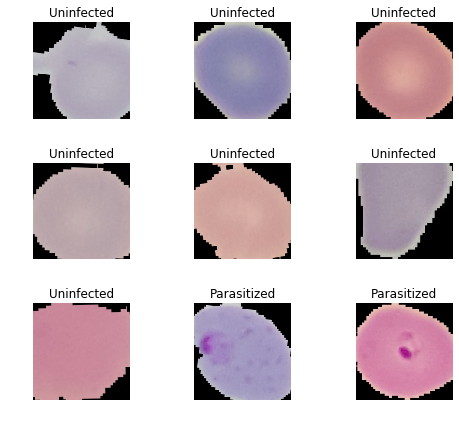

In [12]:
data.show_batch(rows=3, figsize=(7,6))

## Step 2: Training our Model with create_cnn

In order to train our model, we will make use of **Transfer Learning**.

That is, using a model that can efficiently do its job, and applying it to your particular application. This enables the training of neural networks to be faster, and with less data. In this case, we will use **resnet34** as our pretrained model.

To train our specific model using a convolutional neural network, we will use the `create_cnn()` function. More info on this function can be found with `doc(create_cnn())`.

`create_cnn()` outputs a *learner* object that knows what our data is, and what our model is.

In [13]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
# first parameter is our data object
# 2nd parameter is our pre-trained model for transfer learning
# metrics parameter specifies how output will be printed to user

In [14]:
# learn.model # to view our model

## Step 3: Fitting our model

In order to fit our model, we will call `learn.fit_one_cycle`. As referenced from the fast.ai v3 course, `fit_one_cycle` provides a
> dramatically more accurate and faster approach to model fitting as found in [this paper](https://arxiv.org/abs/1803.09820).

The parameter in `learn.fit_one_cycle` is the number of epochs, or number of times we will go over our dataset.

In general, it would be advised to start with `4`, but after fitting the model with `8` epochs, and then `6` epochs, `6` provided the best results.

In [15]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.230804,0.159711,0.942116
2,0.180530,0.117757,0.958265
3,0.158445,0.107613,0.961713
4,0.129256,0.095208,0.964253
5,0.124714,0.093440,0.965161
6,0.127061,0.092681,0.965705


In [16]:
learn.save('stage-1') 

`learn.save()` stores our model in subfolder 'model' within the folder our data is in.
We can now load this model in case we ever have to return to it

## Step 4: Interpretting Results

To interpret our classifications, we will use the `ClassificationInterpretation` with the extension of `.from_learner` since we are interpretting from our *learner* object. 

Documentation on `ClassificationInterpretation` can be found [here](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation)

After storing the results in `interp`, we call `interp.top_losses()` to store the top losses and idxs sorted by the largest. 

By seeing the top losses, we can identify what were the most confident classifications that were in fact wrong.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

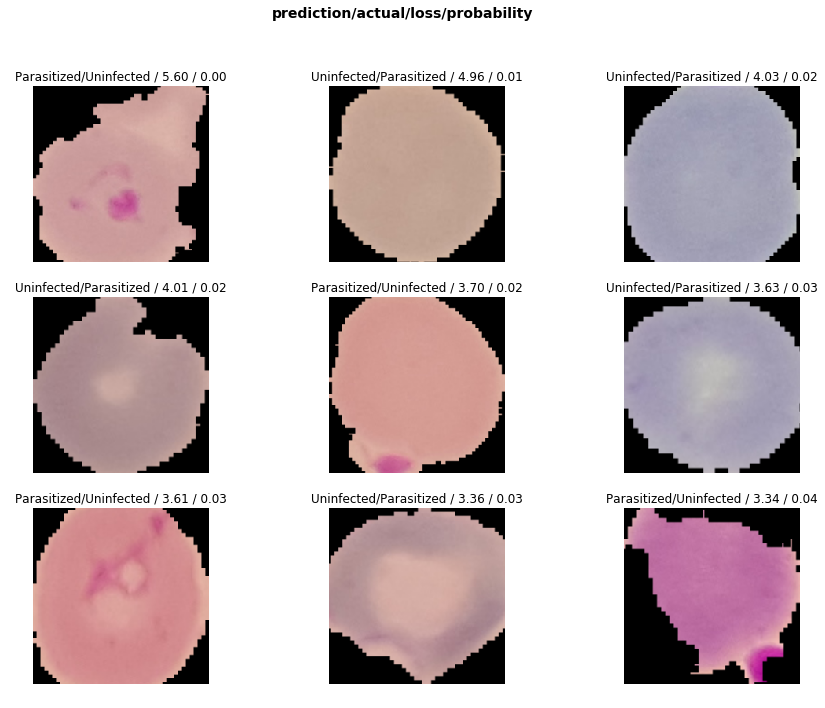

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

Seeing our results in a confusion matrix

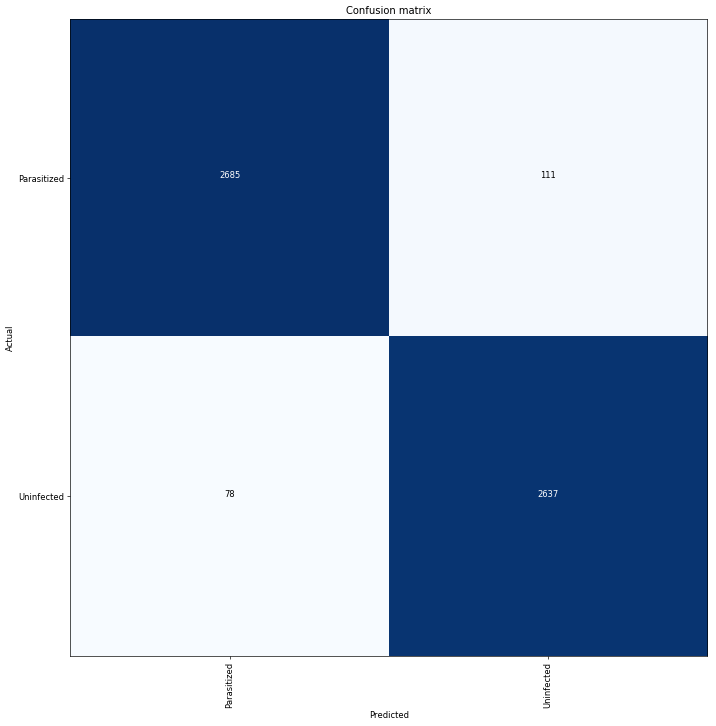

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In order to see a list of the "most confused" classifications by order of magnitude

In [20]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 111), ('Uninfected', 'Parasitized', 78)]

## Step 5: Unfreezing, finding learning rates (LRs), applying differential LRs

We will begin fine tuning our model by first *unfreezing* its layers.

### Unfreeze Layers

Explanation:
When we originally trained our model, calling `fit_one_cycle` only fine-tuned extra layers were added to the end of our network. 

The rest of the layers were *frozen*, and left exactly as it was originally. 

In order to train the entire model, we can call `unfreeze` and see what we get with `learn.fit_one_cycle`.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(4) # fit after unfreezing all layers

epoch,train_loss,valid_loss,accuracy
1,0.162474,0.104859,0.962620
2,0.148422,0.101571,0.966612
3,0.116746,0.081033,0.969516
4,0.100678,0.075911,0.972056


In [30]:
learn.save('stage-1-unfreeze') # save model

In this case, *unfreezing* our model already provided an increase in classification accuracy.

Now that we have a fitted model after unfreezing, we can see if our model improves by loading our originally saved model, and finding the optimal learning rate with `learn.lr_find()`, and using that optimal learning rate after unfreezing again.

In [31]:
learn.load('stage-1'); # load previous model

### Finding optimal learning rate hyperparameter

A good explanation of lr_find could be found at 1:13:28 in [this video lecture](https://www.youtube.com/watch?v=IPBSB1HLNLo) of fastai Deep Learning Part 1 2018 Lesson 1.

From [fastai-lesson-1.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb),

> It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

In summary, the video points out that after calling `lr_find()`, a very small learning rate is first chosen. Next, the learning rate will constantly increase, in order to find the location of the lowest *Loss*. This positive rate of change in learning rate continues until the loss starts increasing. When the loss begins increasing, the function stops running and we can then view a plot of learning rates against the loss function with `recorder.plot()`.

What is the the Loss Function?

It can be summarized as the difference between the actual output and the predicted output.


In [32]:
learn.lr_find() # call this function to render optimal learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


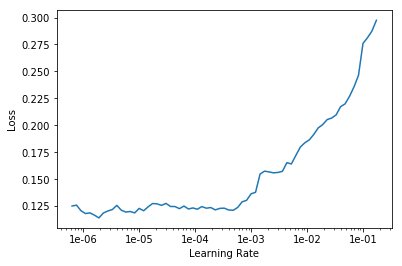

In [33]:
learn.recorder.plot()

In [36]:
?learn.fit_one_cycle

By looking at the above plot, we can possibly improve our model by choosing a range of learning rates from `1e-5, to 1e-3`. This range was chosen by using a range of rates much smaller than the point at which the loss begins increasing.

To compare with the learning rate our original model used, we would call `?learn.fit_one_cycle`. This shows that the defauly learning rate used was `.003`. Our new learning rate will be of lower magnitude.

We will first unfreeze our loaded model, and then call `learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))`.
As you can see, we will run `4` epochs, and use a range of learning rates by using the `max_lr` parameter.

Let's see our results. 

In [37]:
learn.unfreeze() # unfreeze again since we loaded our originally frozen model
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.138204,0.110408,0.961169
2,0.118953,0.081764,0.970060
3,0.111013,0.076145,0.972419
4,0.090435,0.070895,0.973145


This was fun to watch!

Further fine-tuning of the model resulted in **97.3% accuracy**.

Don't forget to save!

In [3]:
learn.save('stage-2')

NameError: name 'learn' is not defined

## Summary

The best results occured after fine tuning the model by unfreezing the layers with `unfreeze`, calling `lr_find` and calling `learn.fit_one_cylce` with `4` epochs, and a range learning rates from `1e-5` to `1e-3`.

Applying this general coding approach to deep learning in computer vision was an amazing way to learn how to actually apply principles on an actual dataset.

